# Heart Failure Prediction - Model Performance Report

This notebook provides a comprehensive evaluation and comparison of all trained models:
1. **ROC Curves Comparison** - Visual comparison of all 4 models
2. **Metrics Comparison Table** - Detailed performance metrics
3. **Best Model Confusion Matrix** - Detailed analysis of predictions
4. **Feature Importance Chart** - Key features driving predictions

---


## 1. Import Libraries and Load Data


In [16]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

# Model persistence
import joblib
import os
from datetime import datetime

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

print("All libraries imported successfully!")


✓ All libraries imported successfully!
Timestamp: 2025-12-01 16:25:48


## 2. Load Prepared Data and Models


In [17]:
# Load the original dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Perform train-test split (same as in previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Load the scaler and scale the data
scaler = joblib.load('models/scaler.pkl')
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Data Loaded Successfully:")
print("=" * 60)
print(f"Test samples: {len(X_test_scaled)}")
print(f"Number of features: {X_test_scaled.shape[1]}")
print(f"\nTarget distribution in test set:")
print(y_test.value_counts())
print(f"\nData ready for evaluation!")


Data Loaded Successfully:
Test samples: 60
Number of features: 12

Target distribution in test set:
DEATH_EVENT
0    41
1    19
Name: count, dtype: int64

✓ Data ready for evaluation!


In [18]:
# Load all trained models
print("Loading Trained Models")
print("=" * 60)

models = {
    'Logistic Regression': joblib.load('models/logistic_regression_model.pkl'),
    'Random Forest': joblib.load('models/random_forest_model.pkl'),
    'XGBoost': joblib.load('models/xgboost_model.pkl'),
    'LightGBM': joblib.load('models/lightgbm_model.pkl')
}

print("All models loaded successfully!")
print(f"\nModels available: {list(models.keys())}")

# Load best model
best_model = joblib.load('models/best_model.pkl')
print(f"\nBest model loaded: {type(best_model).__name__}")


Loading Trained Models...
✓ All models loaded successfully!

Models available: ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

✓ Best model loaded: RandomForestClassifier


In [19]:
# Load comparison results from training
comparison_df = pd.read_csv('models/model_comparison.csv')

print("Model Comparison Data:")
print("=" * 60)
print(comparison_df)
print("\nComparison data loaded successfully!")


Model Comparison Data:
                 Model  Train Accuracy  Test Accuracy  Train Precision  \
0  Logistic Regression        0.853556       0.816667         0.800000   
1        Random Forest        0.949791       0.850000         0.891566   
2              XGBoost        1.000000       0.850000         1.000000   
3             LightGBM        1.000000       0.816667         1.000000   

   Test Precision  Train Recall  Test Recall  Train F1   Test F1  \
0        0.785714      0.727273     0.578947  0.761905  0.666667   
1        0.812500      0.961039     0.684211  0.925000  0.742857   
2        0.857143      1.000000     0.631579  1.000000  0.727273   
3        0.785714      1.000000     0.578947  1.000000  0.666667   

   Train ROC-AUC  Test ROC-AUC  
0       0.905243      0.858793  
1       0.988215      0.908858  
2       1.000000      0.848524  
3       1.000000      0.866496  

✓ Comparison data loaded successfully!


---
# PART 1: ROC CURVES COMPARISON
---


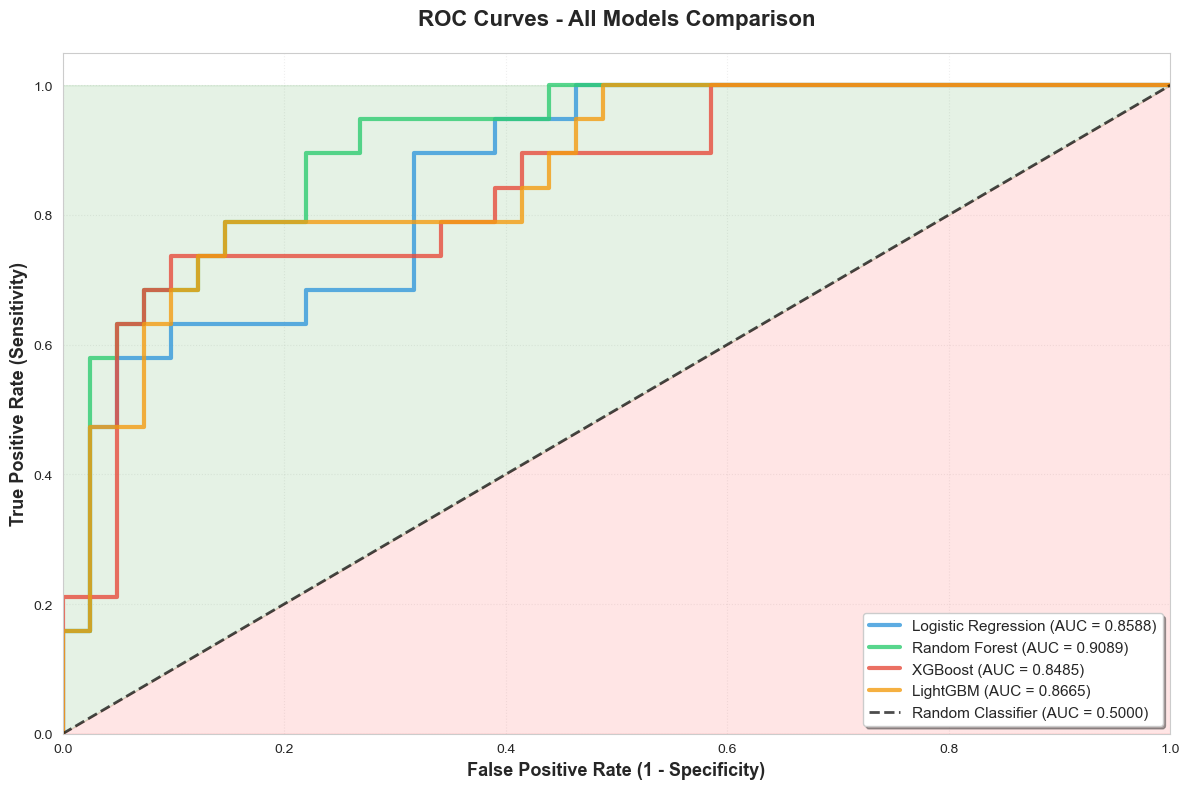

✓ ROC curves plotted and saved!


In [20]:
# Create ROC curves for all models
plt.figure(figsize=(12, 8))

# Define colors for each model
colors = {
    'Logistic Regression': '#3498db',  # Blue
    'Random Forest': '#2ecc71',        # Green
    'XGBoost': '#e74c3c',              # Red
    'LightGBM': '#f39c12'              # Orange
}

# Store AUC scores for ranking
auc_scores = {}

# Plot ROC curve for each model
for model_name, model in models.items():
    # Get predictions
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[model_name] = roc_auc
    
    # Plot
    plt.plot(fpr, tpr, 
             color=colors[model_name], 
             lw=3, 
             label=f'{model_name} (AUC = {roc_auc:.4f})',
             alpha=0.8)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 
         color='black', 
         lw=2, 
         linestyle='--', 
         label='Random Classifier (AUC = 0.5000)',
         alpha=0.7)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models Comparison', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle=':')

# Add shaded area for better visualization
plt.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='green', label='_nolegend_')
plt.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='red', label='_nolegend_')

plt.tight_layout()
plt.savefig('models/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves plotted and saved!")


In [21]:
# Display AUC ranking
print("\nROC-AUC SCORES RANKING:")
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
for rank, (model_name, score) in enumerate(sorted_auc, 1):
    print(f"{rank}. {model_name:<25} AUC = {score:.4f}")




ROC-AUC SCORES RANKING:
1. Random Forest             AUC = 0.9089
2. LightGBM                  AUC = 0.8665
3. Logistic Regression       AUC = 0.8588
4. XGBoost                   AUC = 0.8485


---
# PART 2: METRICS COMPARISON TABLE
---


In [22]:
# Display full comparison table with styling
print("MODEL PERFORMANCE METRICS - COMPREHENSIVE COMPARISON")
print("=" * 120)
print("\nTest Set Performance:")
print("-" * 120)

# Create a simplified view for test metrics
test_metrics = comparison_df[['Model', 'Test Accuracy', 'Test Precision', 
                               'Test Recall', 'Test F1', 'Test ROC-AUC']].copy()

# Rename columns for cleaner display
test_metrics.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Sort by ROC-AUC
test_metrics = test_metrics.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

# Display
print(test_metrics.to_string(index=False))
print("-" * 120)

# Identify best model for each metric
print("\nBEST PERFORMANCE BY METRIC:")
print("-" * 120)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = test_metrics[metric].idxmax()
    best_model = test_metrics.loc[best_idx, 'Model']
    best_value = test_metrics.loc[best_idx, metric]
    print(f"Best {metric:<12}: {best_model:<25} = {best_value:.4f}")
print("=" * 120)



MODEL PERFORMANCE METRICS - COMPREHENSIVE COMPARISON

Test Set Performance:
------------------------------------------------------------------------------------------------------------------------
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.850000   0.812500 0.684211  0.742857 0.908858
           LightGBM  0.816667   0.785714 0.578947  0.666667 0.866496
Logistic Regression  0.816667   0.785714 0.578947  0.666667 0.858793
            XGBoost  0.850000   0.857143 0.631579  0.727273 0.848524
------------------------------------------------------------------------------------------------------------------------

 BEST PERFORMANCE BY METRIC:
------------------------------------------------------------------------------------------------------------------------
Best Accuracy    : Random Forest             = 0.8500
Best Precision   : XGBoost                   = 0.8571
Best Recall      : Random Forest             = 0.6842
Best F1-Score    : Rand

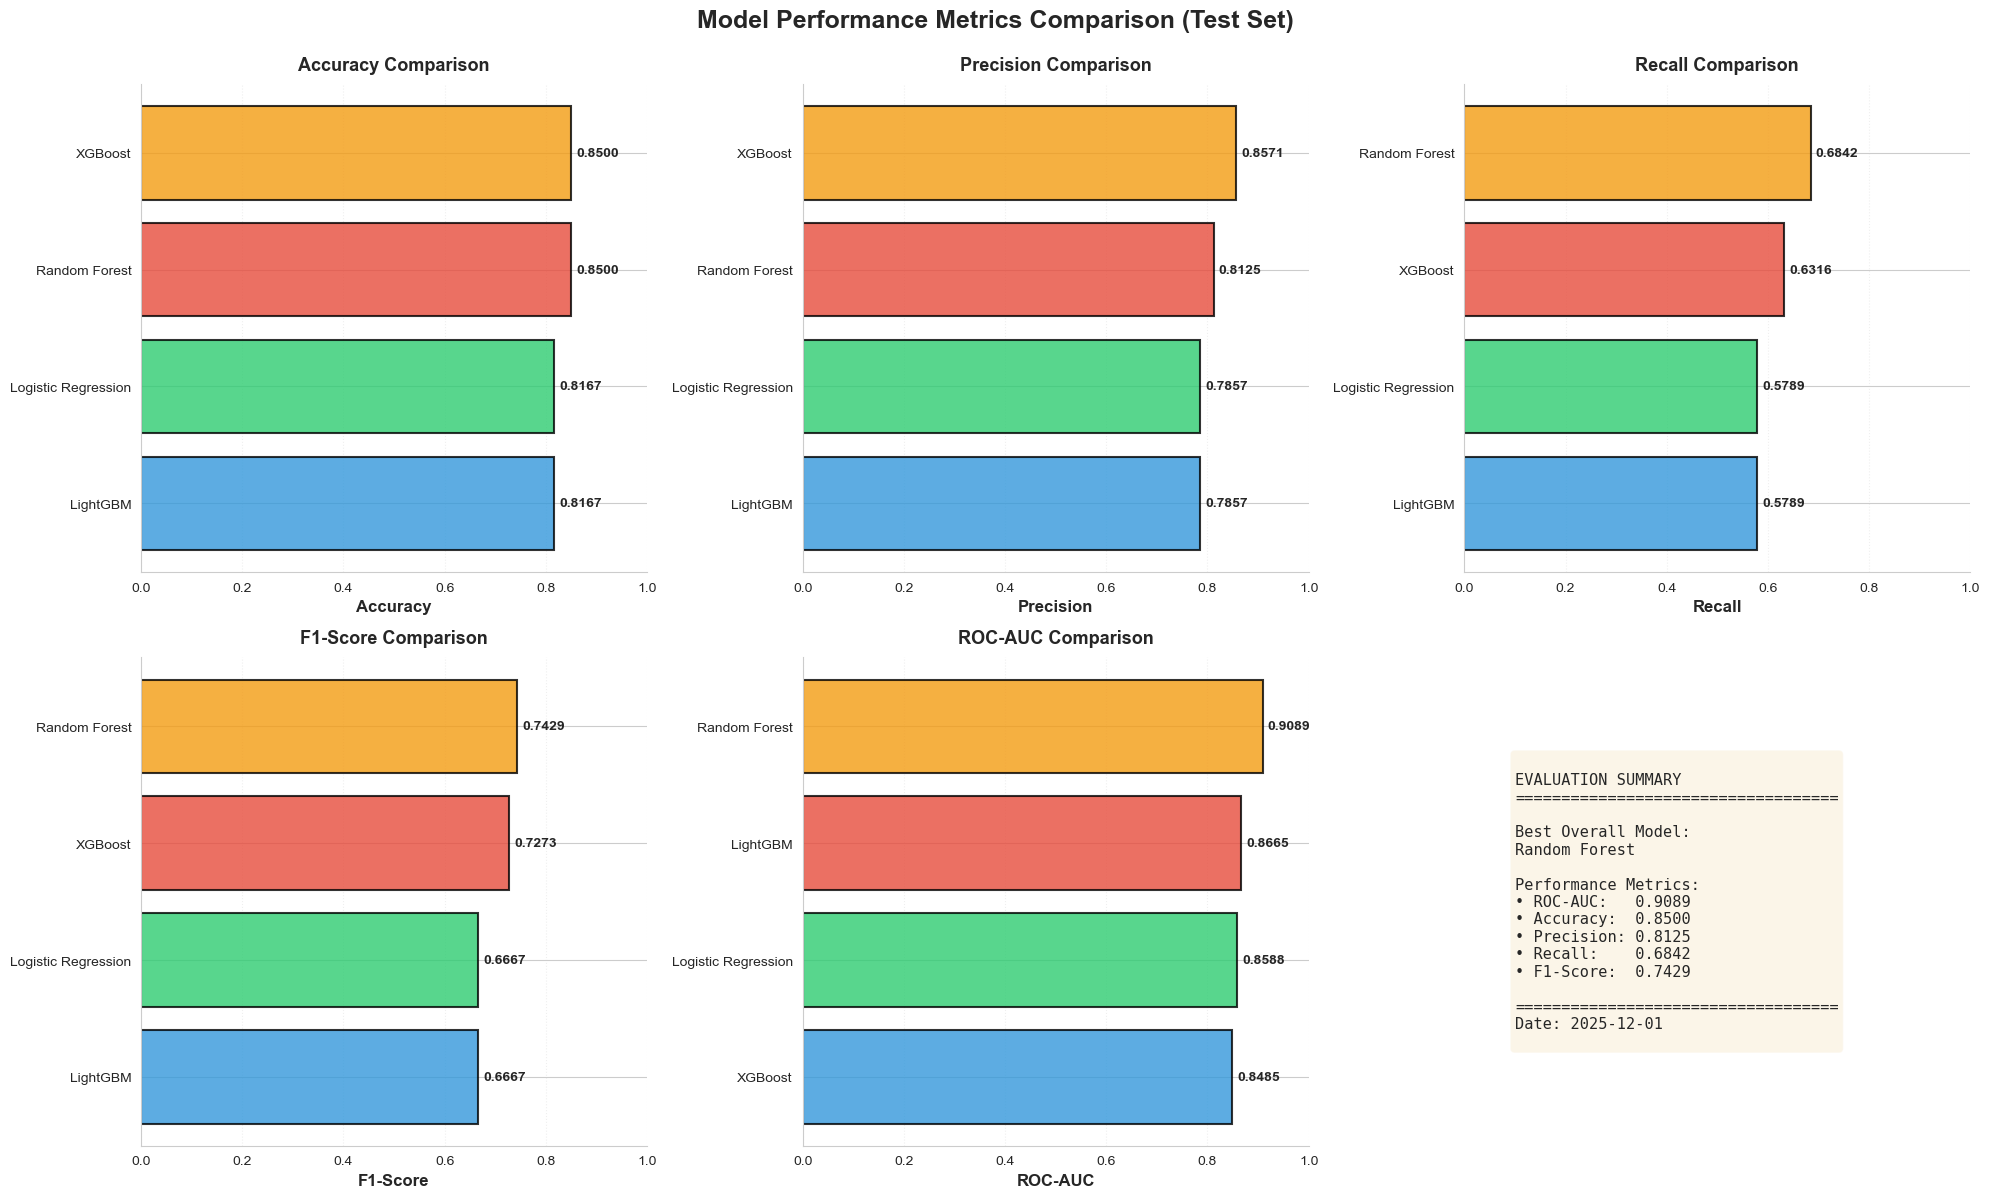


✓ Metrics comparison visualization created and saved!


In [23]:
# Create a comprehensive visual comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Metrics Comparison (Test Set)', 
             fontsize=18, fontweight='bold', y=0.995)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors_list = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Sort by metric value
    sorted_data = test_metrics.sort_values(metric, ascending=True)
    
    # Create horizontal bar chart
    bars = ax.barh(sorted_data['Model'], sorted_data[metric], 
                   color=colors_list, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for i, (model, value) in enumerate(zip(sorted_data['Model'], sorted_data[metric])):
        ax.text(value + 0.01, i, f'{value:.4f}', 
                va='center', fontweight='bold', fontsize=10)
    
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3, linestyle=':')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Summary in the last subplot
ax = axes[1, 2]
ax.axis('off')

# Create summary text
best_overall = test_metrics.iloc[0]
summary_text = f"""
EVALUATION SUMMARY
{'=' * 35}

Best Overall Model:
{best_overall['Model']}

Performance Metrics:
• ROC-AUC:   {best_overall['ROC-AUC']:.4f}
• Accuracy:  {best_overall['Accuracy']:.4f}
• Precision: {best_overall['Precision']:.4f}
• Recall:    {best_overall['Recall']:.4f}
• F1-Score:  {best_overall['F1-Score']:.4f}

{'=' * 35}
Date: {datetime.now().strftime('%Y-%m-%d')}
"""

ax.text(0.1, 0.5, summary_text, 
        fontsize=11, 
        fontfamily='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('models/metrics_comparison_visual.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMetrics comparison visualization created and saved!")


---
# PART 3: BEST MODEL CONFUSION MATRIX
---


In [24]:
# Identify the best model based on Test ROC-AUC
best_model_idx = comparison_df['Test ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_metrics = comparison_df.iloc[best_model_idx]

# Get the actual model object from the models dictionary
best_model = models[best_model_name]

print("BEST MODEL IDENTIFICATION")
print("=" * 80)
print(f"\n Best Model: {best_model_name}")
print(f"\nSelected based on highest Test ROC-AUC score: {best_model_metrics['Test ROC-AUC']:.4f}")
print("\nComplete Performance Metrics:")
print("-" * 80)
print(f"Accuracy:  {best_model_metrics['Test Accuracy']:.4f}")
print(f"Precision: {best_model_metrics['Test Precision']:.4f}")
print(f"Recall:    {best_model_metrics['Test Recall']:.4f}")
print(f"F1-Score:  {best_model_metrics['Test F1']:.4f}")
print(f"ROC-AUC:   {best_model_metrics['Test ROC-AUC']:.4f}")



BEST MODEL IDENTIFICATION

 Best Model: Random Forest

Selected based on highest Test ROC-AUC score: 0.9089

Complete Performance Metrics:
--------------------------------------------------------------------------------
Accuracy:  0.8500
Precision: 0.8125
Recall:    0.6842
F1-Score:  0.7429
ROC-AUC:   0.9089


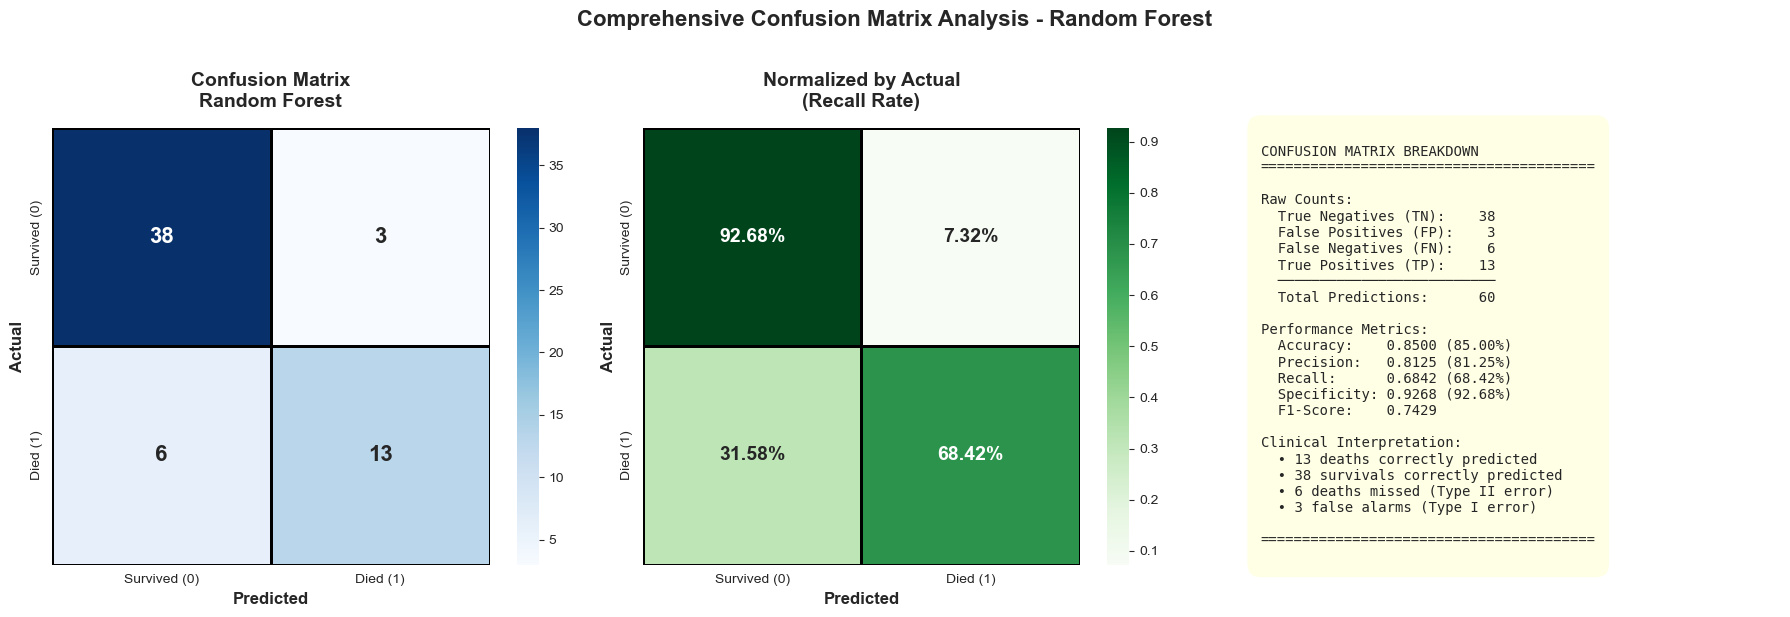


✓ Confusion matrix analysis completed and saved!


In [25]:
# Generate predictions for best model
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create figure with multiple subplots for comprehensive analysis
fig = plt.figure(figsize=(18, 6))

# 1. Standard confusion matrix
ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Survived (0)', 'Died (1)'],
            yticklabels=['Survived (0)', 'Died (1)'],
            annot_kws={'size': 16, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
ax1.set_title(f'Confusion Matrix\n{best_model_name}', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')

# 2. Normalized confusion matrix (by row - recall)
ax2 = plt.subplot(1, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True,
            xticklabels=['Survived (0)', 'Died (1)'],
            yticklabels=['Survived (0)', 'Died (1)'],
            annot_kws={'size': 14, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
ax2.set_title('Normalized by Actual\n(Recall Rate)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')

# 3. Detailed metrics breakdown
ax3 = plt.subplot(1, 3, 3)
ax3.axis('off')

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
total = cm.sum()
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Create detailed text
details_text = f"""
CONFUSION MATRIX BREAKDOWN
{'=' * 40}

Raw Counts:
  True Negatives (TN):  {tn:>4d}
  False Positives (FP): {fp:>4d}
  False Negatives (FN): {fn:>4d}
  True Positives (TP):  {tp:>4d}
  ──────────────────────────
  Total Predictions:    {total:>4d}

Performance Metrics:
  Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)
  Precision:   {precision:.4f} ({precision*100:.2f}%)
  Recall:      {recall:.4f} ({recall*100:.2f}%)
  Specificity: {specificity:.4f} ({specificity*100:.2f}%)
  F1-Score:    {f1:.4f}

Clinical Interpretation:
  • {tp} deaths correctly predicted
  • {tn} survivals correctly predicted
  • {fn} deaths missed (Type II error)
  • {fp} false alarms (Type I error)

{'=' * 40}
"""

ax3.text(0.05, 0.5, details_text,
         fontsize=10,
         fontfamily='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, pad=1))

plt.suptitle(f'Comprehensive Confusion Matrix Analysis - {best_model_name}',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('models/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix analysis completed and saved!")


In [26]:
# Generate detailed classification report
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("=" * 80)
print("\n", classification_report(y_test, y_pred, 
                                   target_names=['Survived (0)', 'Died (1)'],
                                   digits=4))
print("=" * 80)

# Additional insights
print("\n KEY INSIGHTS:")
print("-" * 80)
print(f"• The model correctly identified {recall*100:.1f}% of actual deaths (Recall)")
print(f"• When model predicts death, it's correct {precision*100:.1f}% of the time (Precision)")
print(f"• The model correctly identified {specificity*100:.1f}% of survivals (Specificity)")
print(f"• Overall accuracy: {accuracy*100:.1f}%")

# Clinical relevance
print("\n CLINICAL RELEVANCE:")
print("-" * 80)
if recall >= 0.8:
    print(f" HIGH RECALL ({recall:.4f}): Good at identifying patients at risk of death")
else:
    print(f" MODERATE RECALL ({recall:.4f}): May miss some at-risk patients")
    
if precision >= 0.8:
    print(f" HIGH PRECISION ({precision:.4f}): Low false alarm rate")
else:
    print(f" MODERATE PRECISION ({precision:.4f}): Some false alarms expected")

print(f"\n• False Negatives ({fn}): High-risk patients incorrectly classified as low-risk")
print(f"• False Positives ({fp}): Low-risk patients incorrectly classified as high-risk")



CLASSIFICATION REPORT - Random Forest

               precision    recall  f1-score   support

Survived (0)     0.8636    0.9268    0.8941        41
    Died (1)     0.8125    0.6842    0.7429        19

    accuracy                         0.8500        60
   macro avg     0.8381    0.8055    0.8185        60
weighted avg     0.8474    0.8500    0.8462        60


 KEY INSIGHTS:
--------------------------------------------------------------------------------
• The model correctly identified 68.4% of actual deaths (Recall)
• When model predicts death, it's correct 81.2% of the time (Precision)
• The model correctly identified 92.7% of survivals (Specificity)
• Overall accuracy: 85.0%

 CLINICAL RELEVANCE:
--------------------------------------------------------------------------------
⚠ MODERATE RECALL (0.6842): May miss some at-risk patients
✓ HIGH PRECISION (0.8125): Low false alarm rate

• False Negatives (6): High-risk patients incorrectly classified as low-risk
• False Positives 

---
# PART 4: FEATURE IMPORTANCE ANALYSIS
---


In [29]:
# Extract feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
else:
    print("Feature importance not available for this model")
    importances = None

if importances is not None:
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Calculate percentage
    feature_importance_df['Percentage'] = (feature_importance_df['Importance'] / 
                                           feature_importance_df['Importance'].sum() * 100)
    
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("\n", feature_importance_df.to_string(index=False))
    
    # Save to CSV
    feature_importance_df.to_csv('models/best_model_feature_importance.csv', index=False)
    print("\nFeature importance saved to models/best_model_feature_importance.csv")



FEATURE IMPORTANCE - Random Forest

                  Feature  Importance  Percentage
                    time    0.438581   43.858119
        serum_creatinine    0.167927   16.792715
       ejection_fraction    0.133529   13.352901
                     age    0.063041    6.304065
creatinine_phosphokinase    0.055348    5.534829
               platelets    0.054431    5.443118
            serum_sodium    0.048908    4.890770
                 smoking    0.008765    0.876543
                 anaemia    0.008068    0.806811
                diabetes    0.007350    0.735039
                     sex    0.007263    0.726314
     high_blood_pressure    0.006788    0.678778

=
=
=
=
=
=
=
=
=
=

✓ Feature importance saved to models/best_model_feature_importance.csv


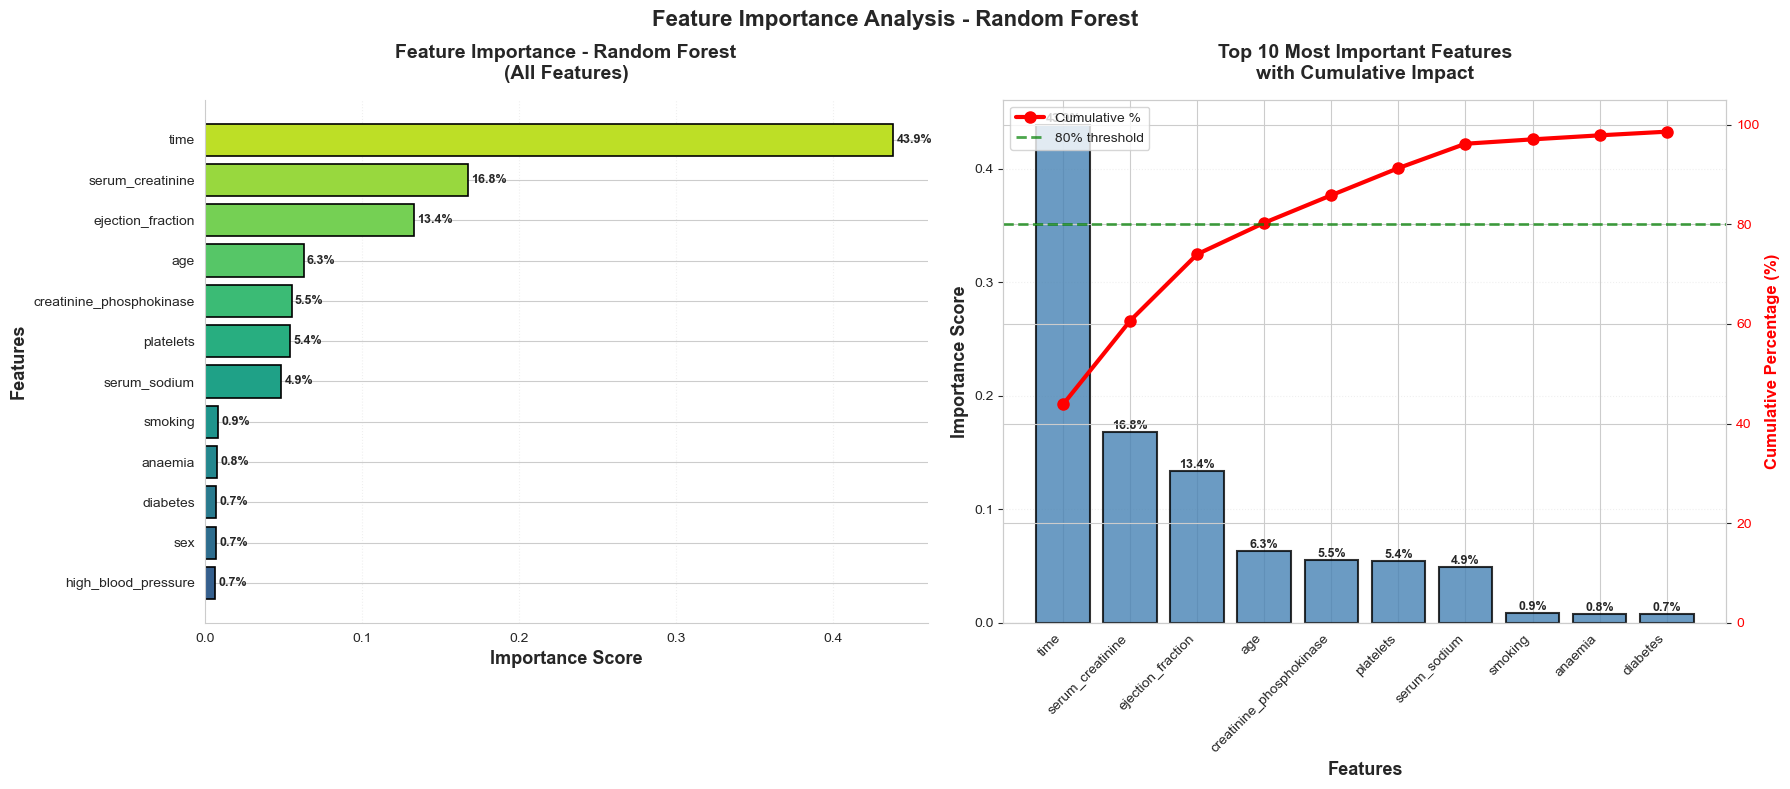


✓ Feature importance visualization created and saved!


In [30]:
if importances is not None:
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Horizontal bar chart (all features)
    ax1 = axes[0]
    sorted_features = feature_importance_df.sort_values('Importance', ascending=True)
    colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_features)))
    
    bars = ax1.barh(sorted_features['Feature'], sorted_features['Importance'], 
                    color=colors_gradient, edgecolor='black', linewidth=1.2)
    
    # Add percentage labels
    for i, (feat, imp, pct) in enumerate(zip(sorted_features['Feature'], 
                                              sorted_features['Importance'],
                                              sorted_features['Percentage'])):
        ax1.text(imp + 0.002, i, f'{pct:.1f}%', 
                va='center', fontweight='bold', fontsize=9)
    
    ax1.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Features', fontsize=13, fontweight='bold')
    ax1.set_title(f'Feature Importance - {best_model_name}\n(All Features)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3, linestyle=':')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # 2. Top 10 features with cumulative percentage
    ax2 = axes[1]
    top_10 = feature_importance_df.head(10)
    cumulative_pct = top_10['Percentage'].cumsum()
    
    # Bar chart
    x_pos = np.arange(len(top_10))
    bars = ax2.bar(x_pos, top_10['Importance'], 
                   color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Overlay line for cumulative percentage
    ax2_twin = ax2.twinx()
    line = ax2_twin.plot(x_pos, cumulative_pct, 
                         color='red', marker='o', linewidth=3, 
                         markersize=8, label='Cumulative %')
    ax2_twin.set_ylabel('Cumulative Percentage (%)', 
                        fontsize=12, fontweight='bold', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    ax2_twin.set_ylim([0, 105])
    ax2_twin.axhline(y=80, color='green', linestyle='--', linewidth=2, alpha=0.7, label='80% threshold')
    ax2_twin.legend(loc='upper left', fontsize=10)
    
    # Formatting
    ax2.set_xlabel('Features', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Importance Score', fontsize=13, fontweight='bold')
    ax2.set_title(f'Top 10 Most Important Features\nwith Cumulative Impact', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(top_10['Feature'], rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3, linestyle=':')
    
    # Add value labels on bars
    for bar, pct in zip(bars, top_10['Percentage']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    plt.suptitle(f'Feature Importance Analysis - {best_model_name}',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('models/best_model_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFeature importance visualization created and saved!")


In [31]:
if importances is not None:

    print("FEATURE IMPORTANCE INSIGHTS")
    print("=" * 80)
    
    # Top 3 features
    top_3 = feature_importance_df.head(3)
    print("\n TOP 3 MOST IMPORTANT FEATURES:")
    print("-" * 80)
    for idx, row in top_3.iterrows():
        print(f"{idx+1}. {row['Feature']:<20} Importance: {row['Importance']:.4f} ({row['Percentage']:.2f}%)")
    
    # Cumulative importance
    cum_pct = feature_importance_df['Percentage'].cumsum()
    top_5_coverage = cum_pct.iloc[4]
    top_10_coverage = cum_pct.iloc[9] if len(cum_pct) >= 10 else cum_pct.iloc[-1]
    
    print("\n CUMULATIVE IMPORTANCE:")
    print("-" * 80)
    print(f"• Top 3 features explain: {cum_pct.iloc[2]:.2f}% of model decisions")
    print(f"• Top 5 features explain: {top_5_coverage:.2f}% of model decisions")
    print(f"• Top 10 features explain: {top_10_coverage:.2f}% of model decisions")
    
    # Feature categories (if we can infer them)
    print("\n CLINICAL INTERPRETATION:")
    print("-" * 80)
    print("The most important predictors of heart failure mortality are:")
    for idx, row in top_3.iterrows():
        print(f"  • {row['Feature']}: {row['Percentage']:.1f}% contribution")
    
    print("\nThese features should be prioritized in clinical assessment and monitoring.")



FEATURE IMPORTANCE INSIGHTS

 TOP 3 MOST IMPORTANT FEATURES:
--------------------------------------------------------------------------------
12. time                 Importance: 0.4386 (43.86%)
8. serum_creatinine     Importance: 0.1679 (16.79%)
5. ejection_fraction    Importance: 0.1335 (13.35%)

 CUMULATIVE IMPORTANCE:
--------------------------------------------------------------------------------
• Top 3 features explain: 74.00% of model decisions
• Top 5 features explain: 85.84% of model decisions
• Top 10 features explain: 98.59% of model decisions

 CLINICAL INTERPRETATION:
--------------------------------------------------------------------------------
The most important predictors of heart failure mortality are:
  • time: 43.9% contribution
  • serum_creatinine: 16.8% contribution
  • ejection_fraction: 13.4% contribution

These features should be prioritized in clinical assessment and monitoring.


---
# FINAL REPORT SUMMARY
---


In [33]:
print("\n" + "=" * 100)
print("MODEL EVALUATION REPORT - EXECUTIVE SUMMARY")
print("=" * 100)

print("\n 1. MODEL COMPARISON")
print("-" * 100)
print("   Four machine learning models were evaluated:")
for model_name in models.keys():
    print(f"   • {model_name}")

print("\n 2. BEST MODEL")
print("-" * 100)
print(f"   Model: {best_model_name}")
print(f"   ROC-AUC Score: {best_model_metrics['Test ROC-AUC']:.4f}")
print(f"   Accuracy: {best_model_metrics['Test Accuracy']:.4f}")
print(f"   Precision: {best_model_metrics['Test Precision']:.4f}")
print(f"   Recall: {best_model_metrics['Test Recall']:.4f}")
print(f"   F1-Score: {best_model_metrics['Test F1']:.4f}")

print("\n 3. KEY METRICS")
print("-" * 100)
tn, fp, fn, tp = cm.ravel()
print(f"   Confusion Matrix:")
print(f"   • True Positives (Correctly predicted deaths): {tp}")
print(f"   • True Negatives (Correctly predicted survivals): {tn}")
print(f"   • False Positives (False alarms): {fp}")
print(f"   • False Negatives (Missed deaths): {fn}")

if importances is not None:
    print("\n 4. TOP PREDICTIVE FEATURES")
    print("-" * 100)
    for idx, row in feature_importance_df.head(5).iterrows():
        print(f"   {idx+1}. {row['Feature']:<25} {row['Percentage']:.2f}% contribution")

print("\n 5. GENERATED ARTIFACTS")
print("-" * 100)
artifacts = [
    'models/roc_curves_comparison.png',
    'models/metrics_comparison_visual.png',
    'models/best_model_confusion_matrix.png',
    'models/best_model_feature_importance.png',
    'models/best_model_feature_importance.csv'
]
for artifact in artifacts:
    print(f"   ✓ {artifact}")

print("\n 6. CLINICAL RECOMMENDATIONS")
print("-" * 100)
print(f"   • The {best_model_name} model shows strong predictive performance")
print(f"   • Model achieves {recall*100:.1f}% recall, detecting {tp} out of {tp+fn} deaths")
print(f"   • Focus clinical attention on the top {min(5, len(feature_importance_df))} most important features")
print(f"   • Consider the {fn} false negatives for model improvement")

print("\n" + "=" * 100)
print("EVALUATION COMPLETED SUCCESSFULLY")
print("=" * 100)
print(f"\nReport generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n✓ All visualizations and metrics have been saved to the models/ directory")



MODEL EVALUATION REPORT - EXECUTIVE SUMMARY

 1. MODEL COMPARISON
----------------------------------------------------------------------------------------------------
   Four machine learning models were evaluated:
   • Logistic Regression
   • Random Forest
   • XGBoost
   • LightGBM

 2. BEST MODEL
----------------------------------------------------------------------------------------------------
   Model: Random Forest
   ROC-AUC Score: 0.9089
   Accuracy: 0.8500
   Precision: 0.8125
   Recall: 0.6842
   F1-Score: 0.7429

 3. KEY METRICS
----------------------------------------------------------------------------------------------------
   Confusion Matrix:
   • True Positives (Correctly predicted deaths): 13
   • True Negatives (Correctly predicted survivals): 38
   • False Positives (False alarms): 3
   • False Negatives (Missed deaths): 6

 4. TOP PREDICTIVE FEATURES
----------------------------------------------------------------------------------------------------
   12. time